In [110]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from scipy.stats import loguniform
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [111]:
import kagglehub
path = kagglehub.dataset_download("yasserh/titanic-dataset")
print(f"Dataset downloaded to: {path}")

Dataset downloaded to: /home/manousos/.cache/kagglehub/datasets/yasserh/titanic-dataset/versions/1


In [112]:
import os
import shutil

files = os.listdir(path)
print(f"Files in the dataset directory: {files}")

csv_file = [file for file in files if file.endswith('.csv')][0]

DATA_DIR = '../data'

os.makedirs(DATA_DIR, exist_ok=True)

source_csv_path = os.path.join(path, csv_file)
print(f"Source CSV file path: {source_csv_path}\n")

target_csv_path = os.path.join(DATA_DIR, csv_file)
print(f"CSV file path: {target_csv_path}")

shutil.copy(source_csv_path, target_csv_path)

Files in the dataset directory: ['Titanic-Dataset.csv', 'titanic_preprocessed.csv']
Source CSV file path: /home/manousos/.cache/kagglehub/datasets/yasserh/titanic-dataset/versions/1/Titanic-Dataset.csv

CSV file path: ../data/Titanic-Dataset.csv


'../data/Titanic-Dataset.csv'

In [113]:
import pandas as pd
data = pd.read_csv(target_csv_path)
print(data.head())
print(data.info())
print(data.isnull().sum())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
<c

In [114]:
# Feature Engineering

def add_features(df):
    df = df.copy() # To avoid modifying the original dataframe
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    return df

drop_features = ['PassengerId', 'Name', 'Ticket', 'Cabin','SibSp', 'Parch'] # Features to drop

In [115]:
feature_eng = Pipeline(steps=[
    ('add_features', FunctionTransformer(add_features)),
    ('drop_features', FunctionTransformer(lambda X: X.drop(columns=drop_features)))
]) 

In [116]:
# Defining feature columns for preprocessing
numeric_features = ['Age', 'Fare', 'FamilySize'] # Numerical features
categorical_features = ['Pclass', 'Sex', 'Embarked', 'IsAlone'] # Categorical features

# Creating preprocessing pipelines for numerical and categorical data
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])




In [117]:
# Combining both pipelines into a ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features),
],
    remainder='passthrough'  # To keep the newly created features
)



In [118]:
# Creating the final pipeline with preprocessing and classifier
pipeline = Pipeline(steps=[
    ('feature_eng', feature_eng),
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000)),    
])

In [119]:
param_distributions = {
    'classifier__C': loguniform(1e-3,1e3), # parameter chaining for logistic regression
    'classifier__penalty': ['l1','l2'],
    'classifier__solver': ['liblinear', 'saga']
}

# Cross-validation setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Setting up RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=50,
    cv=skf,
    verbose=1,
    n_jobs=-1,
    scoring='accuracy',
    random_state=42
)

In [120]:
# Fitting the model
X = data.drop('Survived', axis=1)
y = data['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Measuring time taken for Randomized Search
start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()

print(f"Randomized Search took {end_time - start_time:.2f} seconds")



Fitting 5 folds for each of 50 candidates, totalling 250 fits


Randomized Search took 0.95 seconds


/home/manousos/anaconda3/envs/my_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [121]:
# Evaluating the model

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Best Hyperparameters:", random_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))



Best Hyperparameters: {'classifier__C': 3.584985580340472, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Accuracy: 0.7988826815642458
Confusion Matrix:
 [[91 14]
 [22 52]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.87      0.83       105
           1       0.79      0.70      0.74        74

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



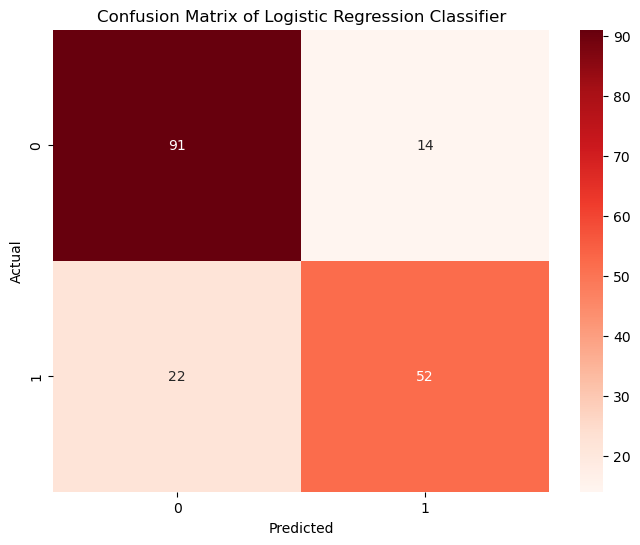

In [122]:
# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Logistic Regression Classifier')
plt.show()

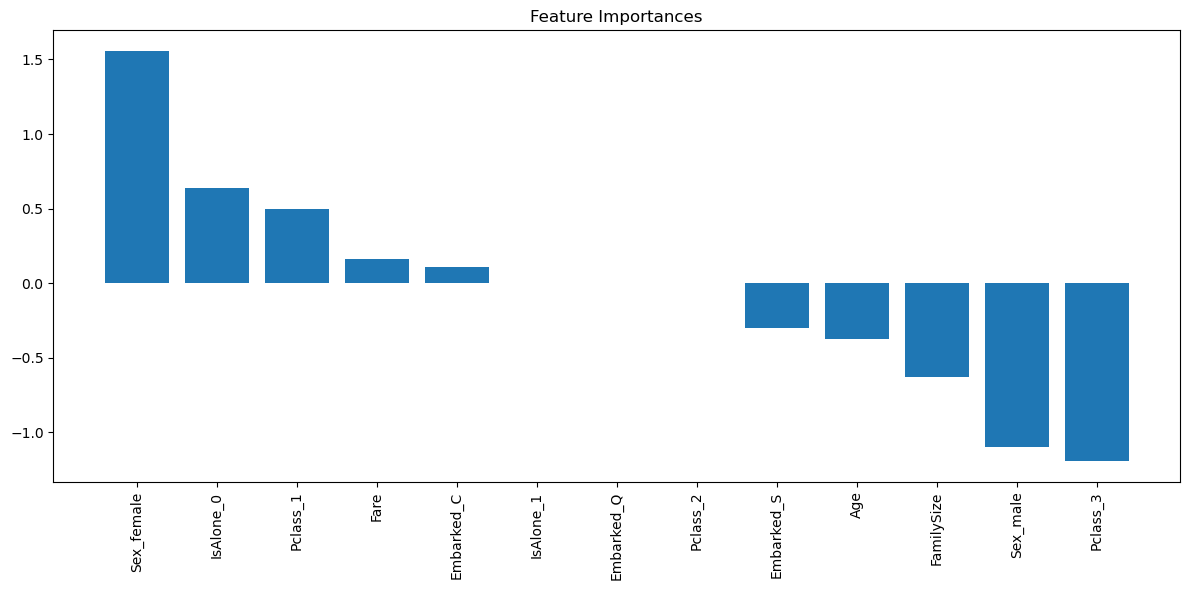

In [123]:
# Function to get feature names after ColumnTransformer
def get_feature_names(column_transformer):
    output_features = []
    for name, transformer, columns in column_transformer.transformers_:

        if name == "remainder":
            continue
        
        if isinstance(transformer, Pipeline):
            transformer = transformer.steps[-1][1]  # Last step

        if hasattr(transformer, "get_feature_names_out"):
            names = transformer.get_feature_names_out(columns)
        else:
            names = columns

        output_features.extend(names)

    return output_features

# Getting feature names after preprocessing
feature_names = get_feature_names(best_model.named_steps['preprocessor'])

# Displaying feature importances

def plot_feature_importances(model, feature_names):
    if hasattr(model.named_steps['classifier'], 'coef_'):
        importances = model.named_steps['classifier'].coef_[0]
        indices = np.argsort(importances)[::-1]

        plt.figure(figsize=(12,6))
        plt.title("Feature Importances")
        plt.bar(range(len(importances)), importances[indices])
        plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
        plt.tight_layout()
        plt.show()
    else:
        print("The classifier does not have feature importances.")

plot_feature_importances(best_model, feature_names)